# HW 3 Problem 1: K-means and EM algorithm for a mixture of Gaussians

## Jennifer Bryson

### Problem 1: 
The goal is to test and compare the K-means algorithm versus the EM algorithm for mixture of Gaussians clustering with unknown cluster means.

First we'll start with the ***K-means algorithm:***

Setup:  Suppose we have a data set $\{x_1, x_2,...,x_N\}$ consisting of $N$ observations of a random D-dimensional Euclidean variable $x$.  We'd like to partition the data set into $K$ clusters ($K$ is given).  For each data point $x_n$ we introduce the variables $r_{n,k}$ where $r_{n,i} = 1$ if $x_n$ is in cluster $i$ and $r_{n,j} = 0$ for all $j \neq i$.  Our objective function will be the distortion measure given by

$J = \sum_{n=1}^N \sum_{k=1}^K r_{n,k} ||x_n - \mu_k||^2$.

Thus we'd like to minimize $J$ with respect to $\mu_k$ and $r_{n,k}$.  To do this, we initialize the Gaussian centers ($\mu_k$).  Then with these fixed $\mu_k$'s we minimize $J$ with respect to the $r_{n,k}$'s.  Next we fix the $r_{n,k}$'s and minimize $J$ with respect to the $\mu_k$'s.  Repeating these two minimization steps until convergence is the K-means algorithm.

Therefore, the algorithm works like this:
1. First update the cluster assignments: $r_{n,k}$ = 1 if $k = argmin_j ||x_n-\mu_j||^2$ and $r_{n,k}$=0 for all other $k$.
1. Then update the means, $\mu_k$ for $k=1,...,K$ by $\mu_k = \frac{\sum_{n=1}^N r_{n,k}x_n}{\sum_{n=1}^N r_{n,k}}$.  In words, the numerator is the sum of all the points assigned to cluster $k$, and the denominator is the number of points assigned to cluster $k$.  Thus $\mu_k$ is simply the mean of all of the points assigned to cluster $k$.  
1. Repeat these two steps until convergence.

And to see how well our program is doing, we will evaluate J after each round.  When J stops changing by much, we can stop repeating the process.

For our specific setting, we will take D=2, so our points $x_i$ are in $R^2$.  And K=4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
D=2 #our data points are in R^D
K=4 #four different Gaussian clouds
N=240 #the number of points that we have to cluster - choose a number divisible by K=4
prob_each_gaussian = [0.25,0.25,0.25,0.25] #assign the probabilities of choosing each of the 4 Gaussians - here we pick equal probabilities

In order to draw our points, we need to pick the Gaussian centers ourselves, but later we will pretend not to know these.

In [3]:
#this makes the collection of points...change the first 3 lines if you want to change the Gaussian centers
centers = [np.array([[2],[2]]).T,np.array([[-3],[1]]).T,np.array([[-2],[-1]]).T,np.array([[1],[-1]]).T]
true_centers_xs = [2,-3,-2,1]
true_centers_ys = [2,1,-1,-1]
var = 0.5
points = np.zeros((N,D))
#now we will randomly select points from our Gaussian distribution, subject to the probabilities of picked each Gaussian
for i in range(N):
    random = np.random.uniform(0,1)
    if random < prob_each_gaussian[0]: #if you pick from the first Gaussian
        points[i,:] = var * np.random.randn(1,D) + centers[0]
    elif random < prob_each_gaussian[0]+prob_each_gaussian[1]: #if you pick from the second Gaussian
        points[i,:] = var * np.random.randn(1,D) + centers[1]
    elif random < prob_each_gaussian[0]+prob_each_gaussian[1]+prob_each_gaussian[2]: #if you pick from the third Gaussian
        points[i,:] = var * np.random.randn(1,D) + centers[2]
    else: #if you pick from the fourth Gaussian
        points[i,:] = var * np.random.randn(1,D) + centers[3]

Let's make some plotting functions to be able to look at the points and the points with cluster centers - once we have them.

In [4]:
def scatter(xs, ys):
    plt.scatter(xs, ys, label='data')
    plt.legend()
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Scatter plot')
    # Uncomment out if you want to save plot as an image file
    # plt.savefig('scatter.png')
    plt.show()

In [5]:
def two_scatter(xs1, ys1, xs2, ys2):
    plt.scatter(xs1, ys1, label='data')
    plt.scatter(xs2, ys2, label='cluster centers')
    plt.legend()
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Scatter plot')
    # Uncomment out if you want to save plot as an image file
    # plt.savefig('scatter2.png')
    plt.show()

In [6]:
def three_scatter(xs1, ys1, xs2, ys2, xs3, ys3):
    plt.scatter(xs1, ys1, label='data')
    plt.scatter(xs2, ys2, label='cluster centers')
    plt.scatter(xs3, ys3, label='true centers')
    plt.legend()
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Scatter plot')
    # Uncomment out if you want to save plot as an image file
    # plt.savefig('scatter2.png')
    plt.show()

Let's look at the points we have.

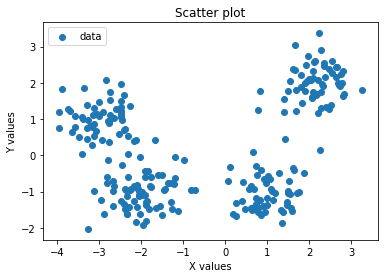

In [7]:
scatter(points[:,0],points[:,1])

In [11]:
#two_scatter(points[:,0],points[:,1],true_centers_xs, true_centers_ys)

Great!  We have our data points, which we will pretend not to know how they were created and we will hope to find 4 cluster centers that minimize the function $J$.

In [12]:
def kmeans(points, at_most_this_many_iterations):
    #first we pick 4 random points in the data to be our 4 cluster centers
    mu =[points[np.random.randint(N),:],points[np.random.randint(N),:],points[np.random.randint(N),:],points[np.random.randint(N),:]]

    #at_most_this_many_iterations = 10
    J = np.zeros((1,at_most_this_many_iterations+1)) #this will be used to determine if we should stop early
    #here we do the first phase step of assigning points to clusters just so we can initialize the J value
    R = np.zeros((N,K))  #clear the center assignments
    for point in range(N):
        norm_list = np.zeros((K,1))
        for i in range(K):
            norm_list[i] = np.linalg.norm(points[point,:] - mu[i])
        R[point,np.argmin(norm_list)]=1
    for n in range(N):
        for k in range(K):
            J[0,0] = J[0,0] + R[n,k]*np.linalg.norm(points[n,:]-mu[k])**2
    #let's look at where we're starting and the J value we start with
    two_scatter(points[:,0],points[:,1],[mu[0][0],mu[1][0],mu[2][0],mu[3][0]],[mu[0][1],mu[1][1],mu[2][1],mu[3][1]] )
    print J

    
    #Now we actually begin our 2 step process.  
    #We will repeat the 2 steps either a set number of times or until we reach a certain level of convergence
    for l in range(at_most_this_many_iterations):
        #in the first phase, we have the centers (mu) fixed and will update the center assignments (R)
        R = np.zeros((N,K))  #clear the center assignments
        for point in range(N):
            norm_list = np.zeros((K,1))
            for i in range(K):
                norm_list[i] = np.linalg.norm(points[point,:] - mu[i])
            R[point,np.argmin(norm_list)]=1
        #this completes phase 1 which assigns the points to the cluster center that minimizes J

        #in the second phase, we fix the center assignments and update the cluster centers to be the average of
        #all the points assigned to that center
        count_c0 = 0
        count_c1 = 0
        count_c2 = 0
        count_c3 = 0
        sum_c0 = [0,0]
        sum_c1 = [0,0]
        sum_c2 = [0,0]
        sum_c3 = [0,0]
        for i in range(N):
            if R[i,0]==1:
                count_c0 = count_c0 + 1
                sum_c0 = sum_c0 + points[i,:]
            elif R[i,1]==1:
                count_c1 = count_c1 + 1
                sum_c1 = sum_c1 + points[i,:]
            elif R[i,2]==1:
                count_c2 = count_c2 + 1
                sum_c2 = sum_c2 + points[i,:]
            else:
                count_c3 = count_c3 + 1
                sum_c3 = sum_c3 + points[i,:]
        
        mu = [sum_c0/count_c0,sum_c1/count_c1,sum_c2/count_c2,sum_c3/count_c3]
        #this completes the second phase
        
        #we can plot our current centers and the data just to see how it's looking
        two_scatter(points[:,0],points[:,1],[mu[0][0],mu[1][0],mu[2][0],mu[3][0]],[mu[0][1],mu[1][1],mu[2][1],mu[3][1]] )
        #three_scatter(points[:,0],points[:,1],[mu[0][0],mu[1][0],mu[2][0],mu[3][0]],[mu[0][1],mu[1][1],mu[2][1],mu[3][1]], true_centers_xs, true_centers_ys)

        #let's compute J for early stopping purposes
        for n in range(N):
            for k in range(K):
                J[0,l+1] = J[0,l+1] + R[n,k]*np.linalg.norm(points[n,:]-mu[k])**2
        print J
        if abs(J[0,l+1] - J[0,l])<0.00001:  #if the J distortion measure didn't decrease by at least 0.00001, then stop iterating
            l=l+1
            break
        l=l+1
    return mu, J[0,l], J[0,0:l+1]

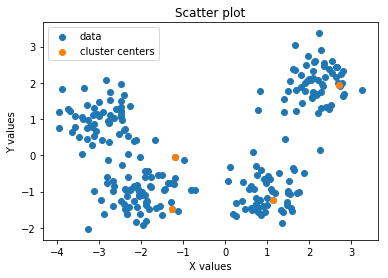

[[ 408.42114561    0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.            0.
     0.        ]]


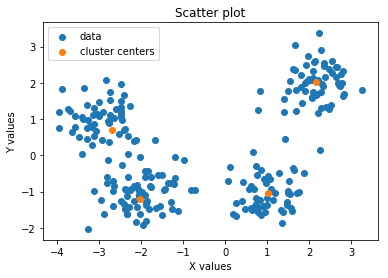

[[ 408.42114561  149.93842467    0.            0.            0.            0.
     0.            0.            0.            0.            0.            0.
     0.        ]]


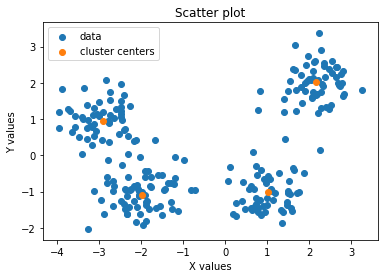

[[ 408.42114561  149.93842467  116.53778247    0.            0.            0.
     0.            0.            0.            0.            0.            0.
     0.        ]]


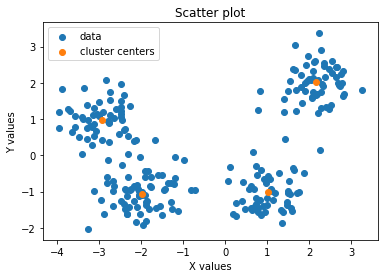

[[ 408.42114561  149.93842467  116.53778247  114.90201799    0.            0.
     0.            0.            0.            0.            0.            0.
     0.        ]]


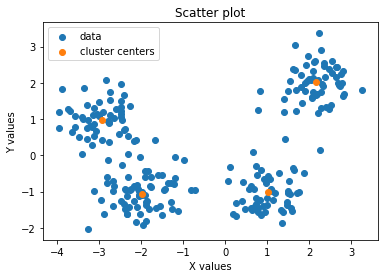

[[ 408.42114561  149.93842467  116.53778247  114.90201799  114.90201799
     0.            0.            0.            0.            0.            0.
     0.            0.        ]]


In [13]:
#Note: sometimes the algorithm picks bad starting points, so if it doesn't look good, just run this line again.
mu_final, J_final, J_all = kmeans(points,12)

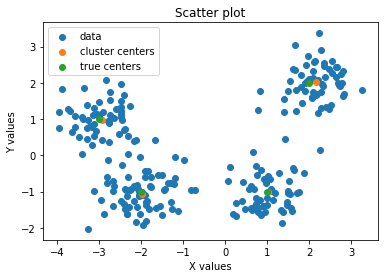

In [14]:
three_scatter(points[:,0],points[:,1],[mu_final[0][0],mu_final[1][0],mu_final[2][0],mu_final[3][0]],[mu_final[0][1],mu_final[1][1],mu_final[2][1],mu_final[3][1]], true_centers_xs, true_centers_ys)


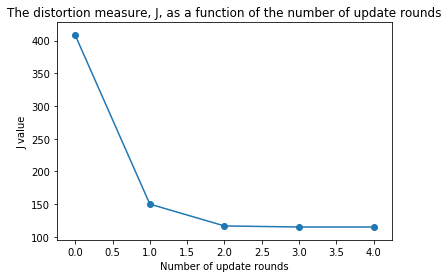

In [15]:
#plot the J values
xs = list(range(0, len(J_all), 1))
ys = J_all
plt.plot(xs, ys, label='data: ys')
plt.scatter(xs, ys, label='data')
plt.xlabel('Number of update rounds')
plt.ylabel('J value')
plt.title('The distortion measure, J, as a function of the number of update rounds')
plt.show()

In [16]:
print mu_final

[array([-2.93807283,  0.97103289]), array([ 2.15939885,  2.00992224]), array([ 1.01172889, -1.02293291]), array([-1.98932802, -1.05407554])]


In [17]:
print centers

[array([[2, 2]]), array([[-3,  1]]), array([[-2, -1]]), array([[ 1, -1]])]


In [18]:
#*********manually edit which centers line up with the mu's each time you run it*********
error_from_actual =  np.linalg.norm(mu_final[0] - centers[1]) + np.linalg.norm(mu_final[1] - centers[0]) + \
    np.linalg.norm(mu_final[2] - centers[3]) + np.linalg.norm(mu_final[3] - centers[2]) 
print error_from_actual

0.308951291964


Great!  We found a very small $L^2$ distance from our learned centers to the true Gaussian centers.  This complete the K-means algorithm.

****

To compare, we will now consider the ***EM algorithm***.  

The goal of the EM algorithm is to maximize the likelihood (or log likelihood).  As before, suppose we have a data set $X = \{x_1, x_2,...,x_N\}$ consisting of $N$ observations of a random D-dimensional Euclidean variable $x$.  Again, suppose we would like to form $K$ clusters, where the probability of each cluster is $\pi_k$ for $k=1,...,K$.  For the case when each data observation is equally likely to have come from any of the $K$ clusters, then $\pi_k = \frac{1}{K}$ for all $k$.  The likelihood of this data collection, X, thus is given by:

$P(X | \pi, \mu, \Sigma) = \prod_{n=1}^N \sum_{k=1}^K \pi_k N(x_n | \mu_k, \Sigma_k) $

For this problem we will assume $\Sigma_k = \sigma^2 I$ for all $k$, and thus 

$P(X | \pi, \mu, \Sigma) = \prod_{n=1}^N \sum_{k=1}^K \pi_k \frac{1}{\sqrt{(2 \pi \sigma^2)^d}} e^{-\frac{1}{2 \sigma^2}(x_n-\mu_k)^T(x_n-\mu_k)}$

We will further assume that $\pi_k = \frac{1}{K}$ for all $k$, giving our final likelihood equation:

$P(X | \pi, \mu, \Sigma) = \prod_{n=1}^N \sum_{k=1}^K \frac{1}{K} \frac{1}{\sqrt{(2 \pi \sigma^2)^d}} e^{-\frac{1}{2 \sigma^2}(x_n-\mu_k)^T(x_n-\mu_k)}$

Taking the derivative with respect to $\mu_k$ of the log likelihood, we find that 

$\mu_k = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk})x_n$, where $N_k = \sum_{n=1}^N \gamma(z_{nk})$ and $\gamma(z_{nk}) = \frac{\pi_k N(x_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j N(x_n | \mu_j, \Sigma_j)}  \bigg(= \frac{ N(x_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K  N(x_n | \mu_j, \Sigma_j)}$ for our case since $\pi_k=\frac{1}{K}$ for all $k \bigg)$.

Therefore, the algorithm works like this:
1. First update the effective cluster assignments $\gamma(z_{nk})$ for $n=1,...,N$ and $k = 1,...,K$.
1. Then update the means, $\mu_k$ for $k=1,...,K$.
1. Repeat these two steps until convergence.

And to see how well our program is doing, we will evaluate the log likelihood.  When the log likelihood stops changing by much, we can stop repeating the process.

Note: For the full EM algorithm there are updates you can do for the $\pi_k$'s and $\Sigma_k$'s (by taking the derivative of the log likelihood with respect to these variables) if we had decided to not assume we know these, but here I took these to be known for simplicity.

In [19]:
def two_dim_gaussian(x,mu):
    #this gives the probability of point x in R^2 of a two dimensional Gaussian where 
    #the variances are the same and are given be var
    output = 1/(2*np.pi*var) * np.exp(-1/(2*var) * np.dot(x-mu,x-mu))
    return output

In [20]:
def em(points, at_most_this_many_iterations):
    #first we pick 4 random points in the data to be our 4 cluster centers
    mu =[points[np.random.randint(N),:],points[np.random.randint(N),:],points[np.random.randint(N),:],points[np.random.randint(N),:]]

    #at_most_this_many_iterations = 10
    L = np.zeros((1,at_most_this_many_iterations+1)) #the log likelihood will be used to determine if we should stop early
    #here we do the first phase step of "assigning" points to clusters just so we can initialize the L value
    gam = np.zeros((N,K))  #clear the center assignments
    for n in range(N):
        for k in range(K):
            denom = 0
            for l in range(K):
                denom = denom + two_dim_gaussian(points[n,:],mu[l])
            gam[n,k] = two_dim_gaussian(points[n,:],mu[k]) / denom
    
    for n in range(N):
        inside = 0
        for k in range(K):
            inside = inside + two_dim_gaussian(points[n,:],mu[k])/K
        L[0,0] = L[0,0] + np.log(inside)
    #let's look at where we're starting and the L value we start with
    two_scatter(points[:,0],points[:,1],[mu[0][0],mu[1][0],mu[2][0],mu[3][0]],[mu[0][1],mu[1][1],mu[2][1],mu[3][1]] )
    print L

    
    #Now we actually begin our 2 step process.  
    #We will repeat the 2 steps either a set number of times or until we reach a certain level of convergence
    for l in range(at_most_this_many_iterations):
        #in the first phase, we have the centers (mu) fixed and will update the center assignments (R)
        gam = np.zeros((N,K))  #clear the center assignments
        for n in range(N):
            for k in range(K):
                denom = 0
                for ll in range(K):
                    denom = denom + two_dim_gaussian(points[n,:],mu[ll])
                gam[n,k] = two_dim_gaussian(points[n,:],mu[k]) / denom
        #this completes phase 1 which assigns the points to the cluster center that minimizes J

        #in the second phase, we fix the center assignments and update the cluster centers to be the average of
        #all the points assigned to that center
        
        for k in range(K):
            num_mu=0
            denom_mu=0
            for n in range(N):
                num_mu = num_mu + gam[n,k]*points[n,:]
                denom_mu = denom_mu + gam[n,k]
            mu[k] = num_mu/denom_mu
        #this completes the second phase
        
        #we can plot our current centers and the data just to see how it's looking
        two_scatter(points[:,0],points[:,1],[mu[0][0],mu[1][0],mu[2][0],mu[3][0]],[mu[0][1],mu[1][1],mu[2][1],mu[3][1]] )
        
        #let's compute L for early stopping purposes
        for n in range(N):
            inside = 0
            for k in range(K):
                inside = inside + two_dim_gaussian(points[n,:],mu[k])/K
            L[0,l+1] = L[0,l+1] + np.log(inside)
        print L
        
        if abs(L[0,l+1] - L[0,l])<0.00001:  #if the log likelihood didn't decrease by at least 0.00001, then stop iterating
            l=l+1
            break
        l=l+1
    return mu, L[0,l], L[0,0:l+1]

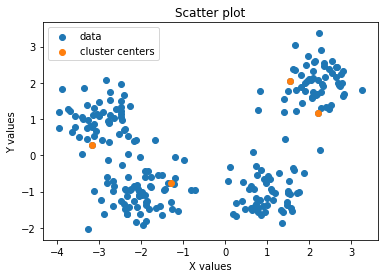

[[-973.50246782    0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]]


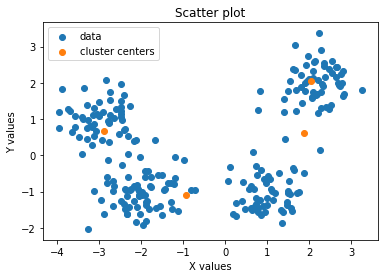

[[-973.50246782 -884.81788405    0.            0.            0.            0.
     0.            0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]]


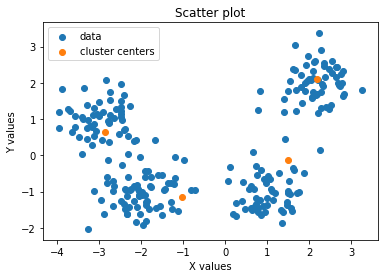

[[-973.50246782 -884.81788405 -812.8059223     0.            0.            0.
     0.            0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]]


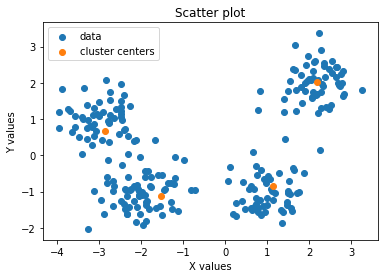

[[-973.50246782 -884.81788405 -812.8059223  -734.32693212    0.            0.
     0.            0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]]


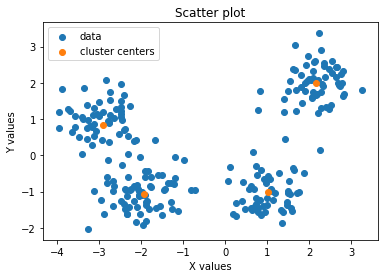

[[-973.50246782 -884.81788405 -812.8059223  -734.32693212 -716.63171082
     0.            0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]]


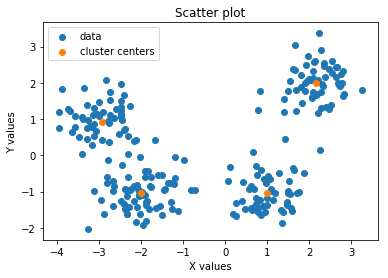

[[-973.50246782 -884.81788405 -812.8059223  -734.32693212 -716.63171082
  -715.38923406    0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]]


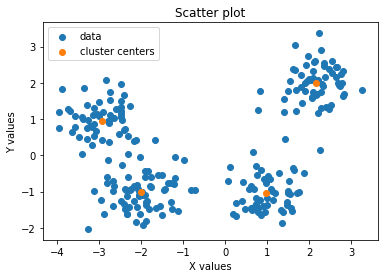

[[-973.50246782 -884.81788405 -812.8059223  -734.32693212 -716.63171082
  -715.38923406 -715.29642569    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]]


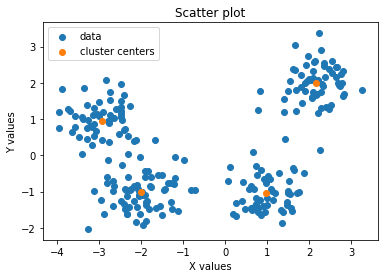

[[-973.50246782 -884.81788405 -812.8059223  -734.32693212 -716.63171082
  -715.38923406 -715.29642569 -715.28900107    0.            0.            0.
     0.            0.            0.            0.            0.        ]]


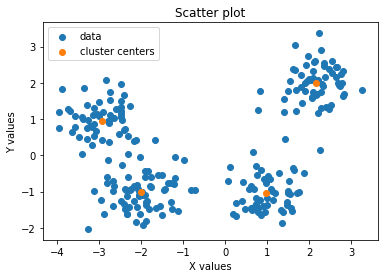

[[-973.50246782 -884.81788405 -812.8059223  -734.32693212 -716.63171082
  -715.38923406 -715.29642569 -715.28900107 -715.28839836    0.            0.
     0.            0.            0.            0.            0.        ]]


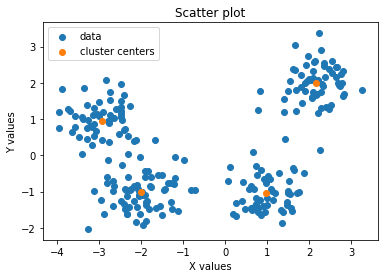

[[-973.50246782 -884.81788405 -812.8059223  -734.32693212 -716.63171082
  -715.38923406 -715.29642569 -715.28900107 -715.28839836 -715.28834934
     0.            0.            0.            0.            0.            0.        ]]


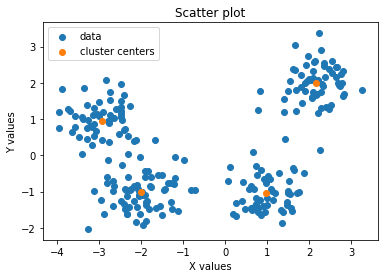

[[-973.50246782 -884.81788405 -812.8059223  -734.32693212 -716.63171082
  -715.38923406 -715.29642569 -715.28900107 -715.28839836 -715.28834934
  -715.28834535    0.            0.            0.            0.            0.        ]]


In [21]:
#Note: sometimes the algorithm picks bad starting points, so if it doesn't look good, just run this line again.
mu_final_em, L_final, L_all = em(points,15)

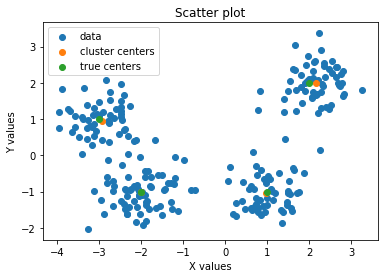

In [22]:
three_scatter(points[:,0],points[:,1],[mu_final_em[0][0],mu_final_em[1][0],mu_final_em[2][0],mu_final_em[3][0]],[mu_final_em[0][1],mu_final_em[1][1],mu_final_em[2][1],mu_final_em[3][1]], true_centers_xs, true_centers_ys)

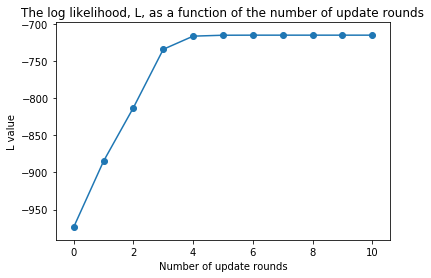

In [23]:
#plot the L values
xs = list(range(0, len(L_all), 1))
ys = L_all
plt.plot(xs, ys, label='data: ys')
plt.scatter(xs, ys, label='data')
plt.xlabel('Number of update rounds')
plt.ylabel('L value')
plt.title('The log likelihood, L, as a function of the number of update rounds')
plt.show()

Note that here we're trying to maximize the log likelihood, whereas for the K-means algorithm we were trying to minimize the distortion measure.  If you wanted the two to look more comparable, you could minimize the negative log likelihood which would flip the graph about the x-axis and thus look more like the graph of J we had in the first part.

In order to compare these two approaches, we can see which one found values for the Gaussian centers that were closest to the true centers.  To do so, we will add up the $L^2$ distances from the true center to the found center for all pairs of centers.

In [24]:
print mu_final_em

[array([-2.00749247, -1.00980352]), array([-2.94225416,  0.95768317]), array([ 2.15678093,  1.98716752]), array([ 0.98180434, -1.03628569])]


In [25]:
print centers

[array([[2, 2]]), array([[-3,  1]]), array([[-2, -1]]), array([[ 1, -1]])]


In [26]:
#******* manually edit this with each time you run the code to match the found mu's with the correct centers********
error_from_actual_em =  np.linalg.norm(mu_final_em[0] - centers[2]) + np.linalg.norm(mu_final_em[1] - centers[1]) + \
    np.linalg.norm(mu_final_em[2] - centers[0]) + np.linalg.norm(mu_final_em[3] - centers[3]) 
print error_from_actual_em

0.281827476367


Excellent!  The sum of the $L^2$ distances is very small!

### Conclusion and comparison

For a few specific trial runs (starting with new data for each trial), here's how the sum of the $L^2$ distances for the K-means algorithm and for the EM algorithm compared:

<font color=magenta>Trial 1</font>
<br>
K-means: 0.545279819041
<br>
EM: 0.534818414898

<font color=magenta>Trial 2</font>
<br>
K-means: 0.391651031615
<br>
EM: 0.375371959802

<font color=magenta>Trial 3</font>
<br>
K-means: 0.308951291964
<br>
EM: 0.281827476367

It looks like the EM algorithm tends to do slightly better, but both work well!

Additionally, sometimes the algorithms don't get close at all.  Running the whole program (get a data set and run both algorithms for this data) 20 times, I counted how many times the means calculated were actually close to the true means (as opposed to a situation like when two cluster centers converge to the same point and thus really just find 3 clusters).  Below we've recorded this accuracy for each method, but note that it is HIGHLY dependent on the random starting means.  This is just meant to give some kind of idea what percentage of random starting means actually work.

<font color=magenta>Overall accuracy:</font> 
<br>
K-means: 85% of the time the calculated means are at least close to the true means
<br>
EM algorithm: 60% of the time the calculated means are at least close to the true means

So it looks like the K-means algorithm has a better chance of getting at least close to the true means, but when they both get close, the EM algorithm gets a little closer.  This might be why I've read that often times the K-means algorithm is used as a preprocessing to the EM algorithm.